## Business Application : Backorder Prediction for Optimal Inventory Management

Problem Statement:

A company in manufacturing and distribution seeks to prevent backorders, where product demand exceeds available inventory, leading to customer dissatisfaction and operational challenges.

Objective:

To create a predictive model that anticipates the likelihood of a product going on backorder. This will enable informed inventory management decisions, reducing backorders and enhancing customer satisfaction.

Key Components:

Data Collection: Historical data includes SKU, inventory levels, lead times, forecasts, sales data, and backorder status.
Backorder Prediction: Develop a model to predict the probability of backorders based on historical data.
Inventory Optimization: Use predictions to optimize inventory levels, reorder points, and lead times, minimizing backorder risk.
Operational Decision-Making: Predictions guide procurement, production, and distribution, preventing backorders by triggering restocking when necessary.
Customer Satisfaction: Minimizing backorders aims to maintain customer satisfaction and prevent revenue loss.

Scope:

The project includes data processing, feature engineering, model development and model comparison.

Key Metrics:

Accuracy: Measure the model's ability to classify products at risk of backorders.

Precision and Recall: Evaluate accuracy and false alarms.

AUC-ROC Score: Assess overall model performance.

### Addressing this challenge enhances supply chain efficiency, reduces costs, and improves the customer experience by ensuring product availability and minimizing backorders.

In [10]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.tree import plot_tree
from sklearn import tree
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc, precision_recall_curve

In [11]:
#Loading the data
df= pd.read_csv('/Users/rishintiwari/Desktop/Fall 2023/Data Mining(DM)/Individual project/Backorderdata.csv')
df.head()

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,3921548,8,12,0,0,0,0,1,1,2,...,0,0.63,0.75,0,No,No,No,Yes,No,No
1,3191009,83,2,33,157,377,603,44,98,148,...,0,0.68,0.66,0,No,No,No,Yes,No,No
2,2935810,8,4,0,0,0,0,0,0,1,...,0,0.73,0.78,0,No,No,No,Yes,No,No
3,2205847,31,4,63,70,160,223,27,90,164,...,0,0.73,0.78,0,No,No,Yes,Yes,No,No
4,4953497,3,12,0,0,0,0,0,0,0,...,0,0.81,0.74,0,No,No,No,Yes,No,No


In [12]:
#Checking the shape of our data
df.shape

(250078, 23)

In [13]:
#Check how many Back orders
df['went_on_backorder'].value_counts()

No     248463
Yes      1615
Name: went_on_backorder, dtype: int64

In [14]:
#checking the Null Values (The Data is clean so we don't have any null values)
df.isnull().sum()

sku                  0
national_inv         0
lead_time            0
in_transit_qty       0
forecast_3_month     0
forecast_6_month     0
forecast_9_month     0
sales_1_month        0
sales_3_month        0
sales_6_month        0
sales_9_month        0
min_bank             0
potential_issue      0
pieces_past_due      0
perf_6_month_avg     0
perf_12_month_avg    0
local_bo_qty         0
deck_risk            0
oe_constraint        0
ppap_risk            0
stop_auto_buy        0
rev_stop             0
went_on_backorder    0
dtype: int64

In [15]:
#Assigning binary variables as 0 / 1 rather than No / Yes
for col in ['potential_issue',
            'deck_risk',
            'oe_constraint',
            'ppap_risk',
            'stop_auto_buy',
            'rev_stop',
            'went_on_backorder']:    
    df[col]=pd.factorize(df[col])[0]

In [16]:
df.head()

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,3921548,8,12,0,0,0,0,1,1,2,...,0,0.63,0.75,0,0,0,0,0,0,0
1,3191009,83,2,33,157,377,603,44,98,148,...,0,0.68,0.66,0,0,0,0,0,0,0
2,2935810,8,4,0,0,0,0,0,0,1,...,0,0.73,0.78,0,0,0,0,0,0,0
3,2205847,31,4,63,70,160,223,27,90,164,...,0,0.73,0.78,0,0,0,1,0,0,0
4,4953497,3,12,0,0,0,0,0,0,0,...,0,0.81,0.74,0,0,0,0,0,0,0


In [17]:
df['perf_12_month_avg'].unique() #Get unique values for Source performance for prior 12 month

array([0.75, 0.66, 0.78, 0.74, 0.96, 0.7 , 0.99, 0.76, 0.71, 0.88, 0.8 ,
       0.86, 0.79, 0.09, 1.  , 0.  , 0.81, 0.67, 0.85, 0.24, 0.98, 0.63,
       0.46, 0.9 , 0.82, 0.93, 0.83, 0.53, 0.64, 0.5 , 0.69, 0.59, 0.97,
       0.16, 0.92, 0.84, 0.89, 0.61, 0.77, 0.42, 0.87, 0.95, 0.35, 0.94,
       0.31, 0.91, 0.34, 0.18, 0.73, 0.13, 0.68, 0.48, 0.45, 0.27, 0.36,
       0.05, 0.14, 0.41, 0.1 , 0.4 , 0.52, 0.6 , 0.32, 0.65, 0.26, 0.37,
       0.56, 0.47, 0.62, 0.3 , 0.23, 0.01, 0.33, 0.28, 0.15, 0.49, 0.72,
       0.57, 0.44, 0.04, 0.55, 0.08, 0.25, 0.22, 0.54, 0.06, 0.21, 0.43,
       0.58, 0.2 , 0.17, 0.12, 0.51, 0.39, 0.19, 0.38, 0.11, 0.29, 0.07,
       0.02, 0.03])

In [18]:
df['perf_6_month_avg']=df['perf_6_month_avg'].replace(-99, np.NaN) #replacing occurrences of -99 with NaN, representation for missing or undefined data 
df['perf_12_month_avg']=df['perf_12_month_avg'].replace(-99, np.NaN)  #replacing occurrences of -99 with NaN, representation for missing or undefined data 

In [19]:
df.fillna(df.median(), inplace=True)
df

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,3921548,8,12,0,0,0,0,1,1,2,...,0,0.63,0.75,0,0,0,0,0,0,0
1,3191009,83,2,33,157,377,603,44,98,148,...,0,0.68,0.66,0,0,0,0,0,0,0
2,2935810,8,4,0,0,0,0,0,0,1,...,0,0.73,0.78,0,0,0,0,0,0,0
3,2205847,31,4,63,70,160,223,27,90,164,...,0,0.73,0.78,0,0,0,1,0,0,0
4,4953497,3,12,0,0,0,0,0,0,0,...,0,0.81,0.74,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250073,3129822,74,8,0,0,0,0,6,18,28,...,0,0.87,0.71,0,0,0,0,0,0,0
250074,3100168,7,12,0,0,1,4,1,4,5,...,0,0.73,0.79,0,0,0,0,0,0,0
250075,3860965,2,8,0,0,0,0,0,0,0,...,0,0.80,0.79,0,0,0,1,0,0,0
250076,3477768,37,8,1,14,28,49,9,25,49,...,0,0.97,0.95,0,0,0,0,0,0,0


In [20]:
df=df.drop(['sku'],axis=1) #Removing the extra columns not used as feature

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250078 entries, 0 to 250077
Data columns (total 22 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   national_inv       250078 non-null  int64  
 1   lead_time          250078 non-null  int64  
 2   in_transit_qty     250078 non-null  int64  
 3   forecast_3_month   250078 non-null  int64  
 4   forecast_6_month   250078 non-null  int64  
 5   forecast_9_month   250078 non-null  int64  
 6   sales_1_month      250078 non-null  int64  
 7   sales_3_month      250078 non-null  int64  
 8   sales_6_month      250078 non-null  int64  
 9   sales_9_month      250078 non-null  int64  
 10  min_bank           250078 non-null  int64  
 11  potential_issue    250078 non-null  int64  
 12  pieces_past_due    250078 non-null  int64  
 13  perf_6_month_avg   250078 non-null  float64
 14  perf_12_month_avg  250078 non-null  float64
 15  local_bo_qty       250078 non-null  int64  
 16  de

In [22]:
# Creating feature matrix 'X' by dropping the 'went_on_backorder' column from the DataFrame 'df'
X = df.drop(['went_on_backorder'], axis=1)
# Creating the target variable 'y' by selecting the 'went_on_backorder' column from the DataFrame 'df'
y = df['went_on_backorder']

In [23]:
# Splitting the feature matrix (X) and the target variable (y) into training and testing sets.
# The test set will comprise 30% of the data and train set 70%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [24]:
scaler = StandardScaler()
X_train= scaler.fit_transform(X_train)
X_test= scaler.transform(X_test)

# Decison Tree Model

In [25]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier(random_state=42)
# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)
#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [26]:
score = clf.score(X_test, y_test)
print(f" Decsion tree Model Accuracy: {score:.2f}")
# Accuracy
accuracy_DT = accuracy_score(y_test, y_pred)
# Confusion Matrix
conf_matrix_Decision_tree = confusion_matrix(y_test, y_pred)
# Classification Report
class_report_DT = classification_report(y_test, y_pred)

print(f'Decision Tree Accuracy: {accuracy_DT}')
print(f'Decision Tree Confusion Matrix: \n{conf_matrix_Decision_tree}')
print(f'Decision Tree Classification Report: \n{class_report_DT}')

 Decsion tree Model Accuracy: 0.99
Decision Tree Accuracy: 0.9884170398805715
Decision Tree Confusion Matrix: 
[[74050   496]
 [  373   105]]
Decision Tree Classification Report: 
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     74546
           1       0.17      0.22      0.19       478

    accuracy                           0.99     75024
   macro avg       0.58      0.61      0.59     75024
weighted avg       0.99      0.99      0.99     75024



In [27]:
# Create a Decision Tree classifier object with limited depth and leaf nodes, using Hyperparameters
clf = DecisionTreeClassifier(criterion="entropy",max_depth=2)
# Train the Decision Tree classifier
clf = clf.fit(X_train, y_train)
#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [28]:
# Model Accuracy after setting Hyperparameter
print("Accuracy after Hyperparameters:",metrics.accuracy_score(y_test, y_pred))

Accuracy after Hyperparameters: 0.9936287054809128


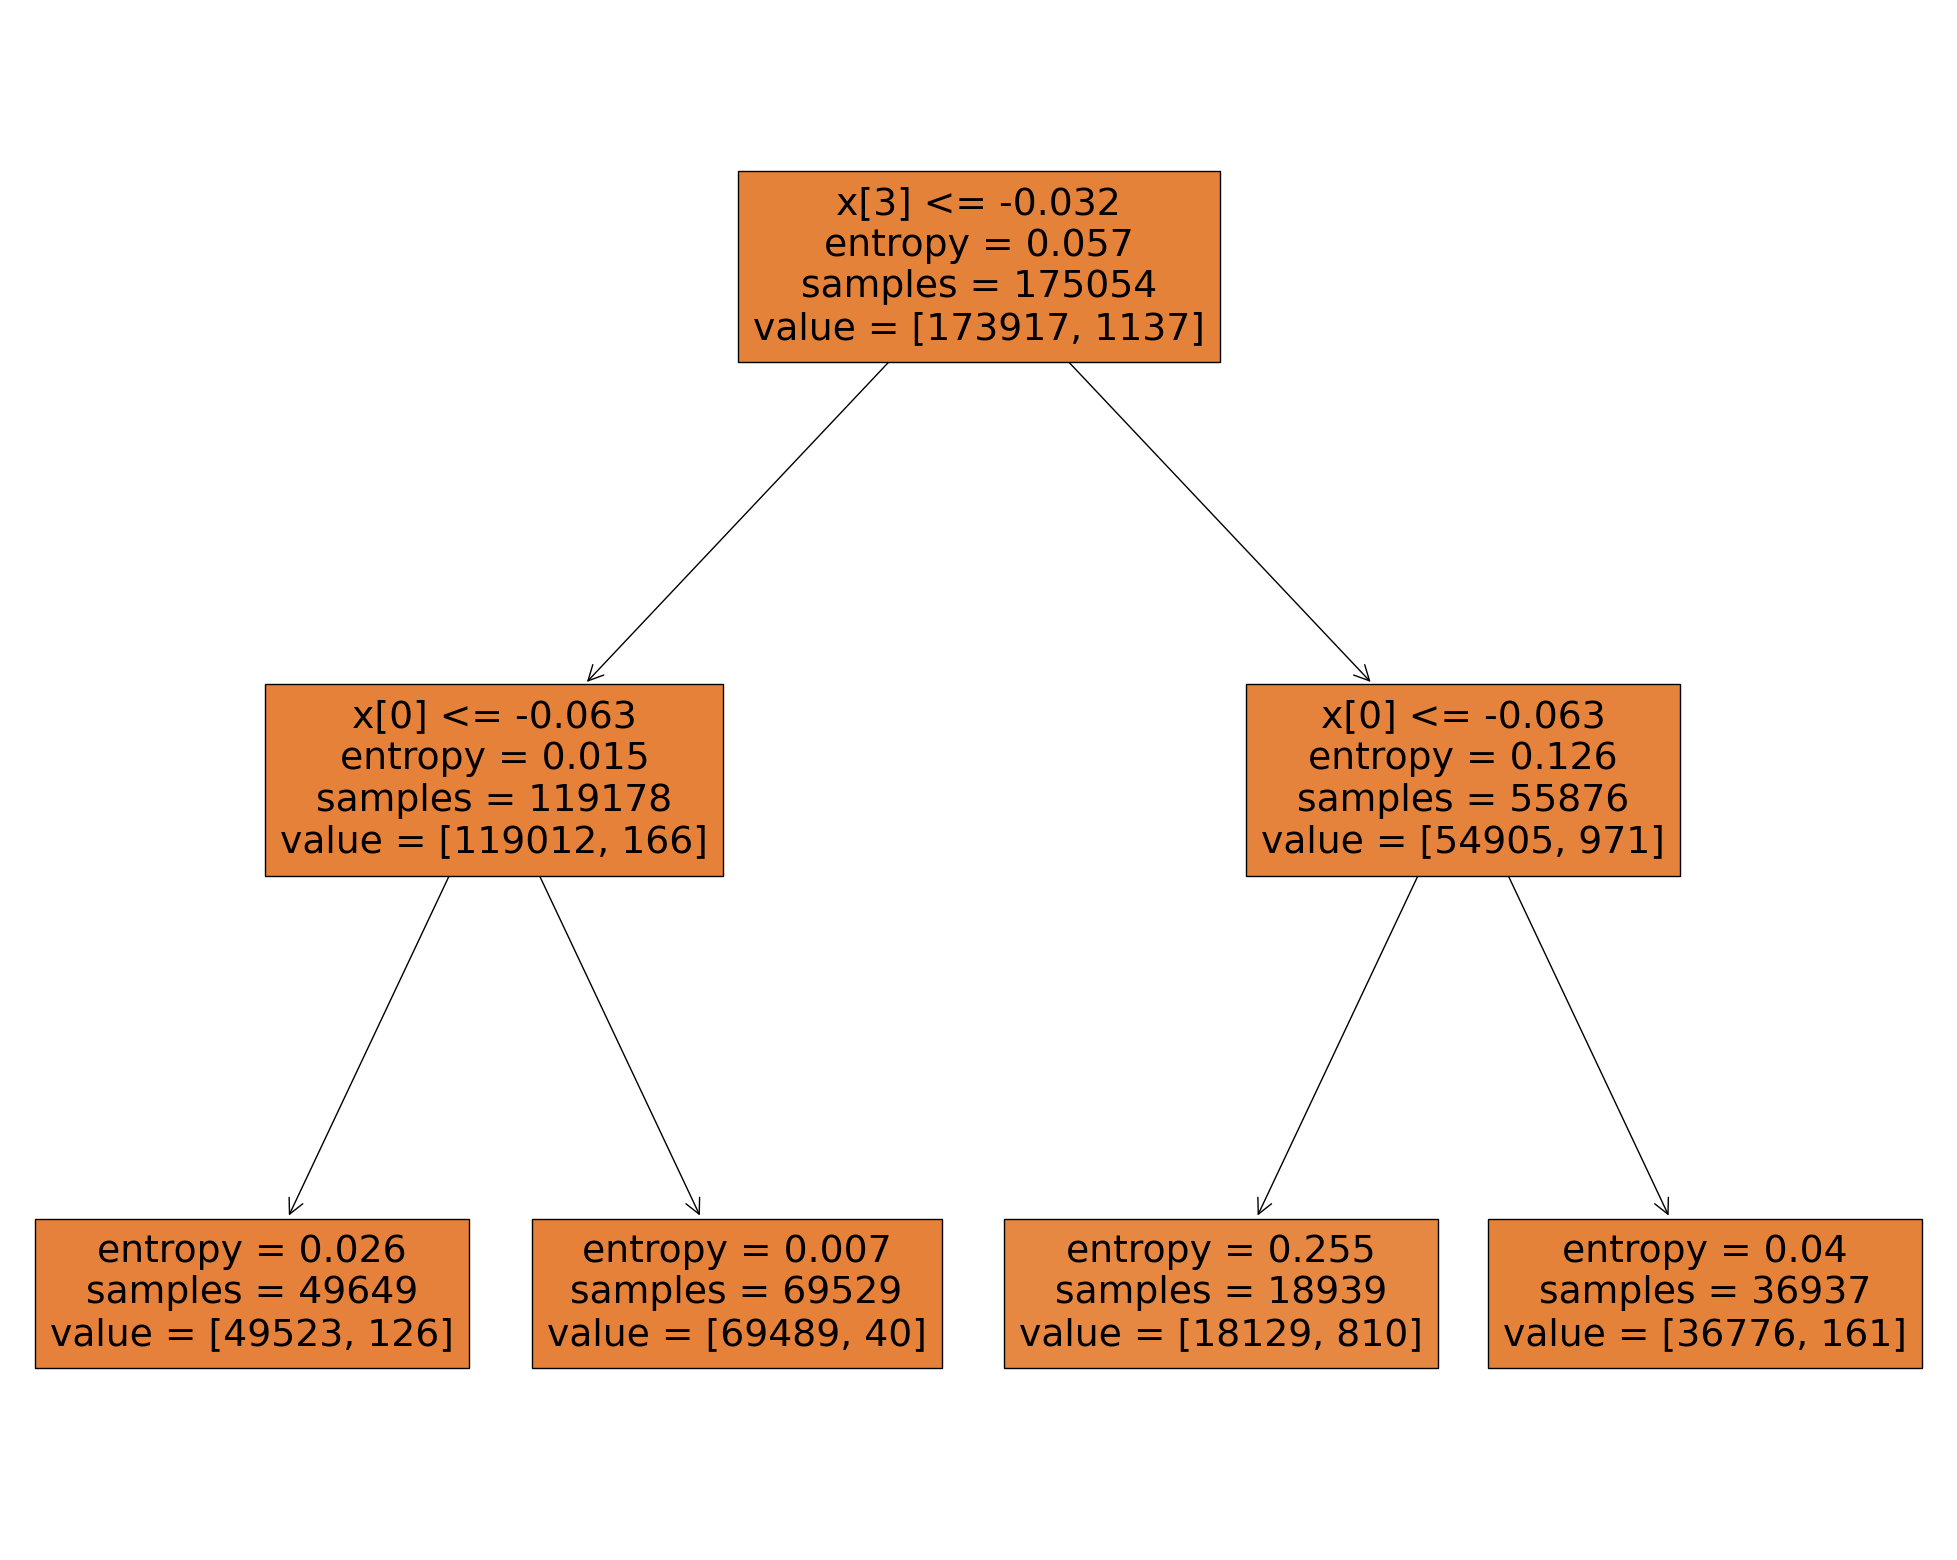

In [29]:
# Plot the Decision Tree with limited depth and leaf nodes
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf,filled=True)

In [30]:
auc = roc_auc_score(y_test, y_pred)
print(auc)

0.5


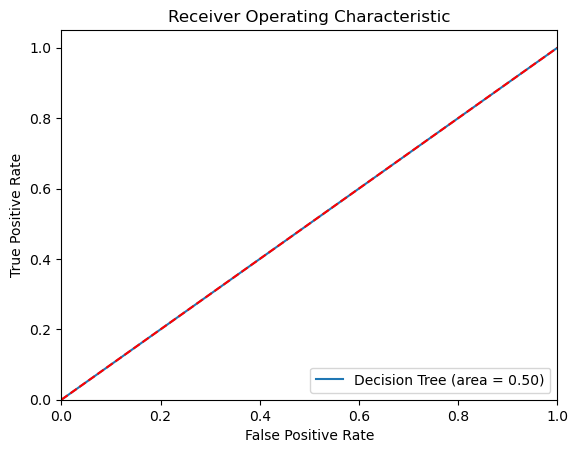

In [31]:
# ROC Curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred)


plt.figure()
plt.plot(fpr, tpr, label='Decision Tree (area = %0.2f)' % roc_auc_score(y_test, y_pred))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Random Forest Model

In [32]:
RF = RandomForestClassifier(n_jobs = -1)
RF.fit(X_train, y_train)
y_pred = RF.predict(X_test)

In [33]:
print('Random Forest Classifier accuracy: %0.3f'% accuracy_score(y_pred, y_test))

Random Forest Classifier accuracy: 0.994


In [34]:
print("Random Forest Classifier report \n", classification_report(y_pred, y_test))

Random Forest Classifier report 
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     74986
           1       0.06      0.71      0.10        38

    accuracy                           0.99     75024
   macro avg       0.53      0.85      0.55     75024
weighted avg       1.00      0.99      1.00     75024



In [35]:
print('roc_auc_score: %0.3f'% roc_auc_score(y_test, y_pred))

roc_auc_score: 0.528


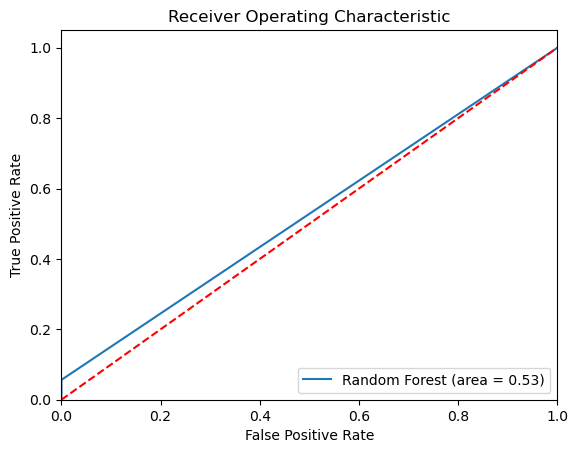

In [36]:
# ROC Curve

 
fpr, tpr, thresholds = roc_curve(y_test, y_pred)


plt.figure()
plt.plot(fpr, tpr, label='Random Forest (area = %0.2f)' % roc_auc_score(y_test, y_pred))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Logsitic Regression

In [37]:
model = LogisticRegression(
    max_iter=1000,  # increase the number of iterations
    n_jobs=-1       # use all processors
)
model.fit(X_train , y_train) 

LogisticRegression(max_iter=1000, n_jobs=-1)

In [38]:
y_pred_logistic = model.predict(X_test)

In [39]:
# Accuracy
accuracy = accuracy_score(y_test, y_pred_logistic)
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_logistic)
# Classification Report
class_report = classification_report(y_test, y_pred_logistic)

print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix: \n{conf_matrix}')
print(f'Classification Report: \n{class_report}')


Accuracy: 0.9936153764128812
Confusion Matrix: 
[[74545     1]
 [  478     0]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     74546
           1       0.00      0.00      0.00       478

    accuracy                           0.99     75024
   macro avg       0.50      0.50      0.50     75024
weighted avg       0.99      0.99      0.99     75024



In [40]:
# Calculating AUC
auc = roc_auc_score(y_test, y_pred_logistic)
print("AUC Score: ", auc)

AUC Score:  0.4999932927320044


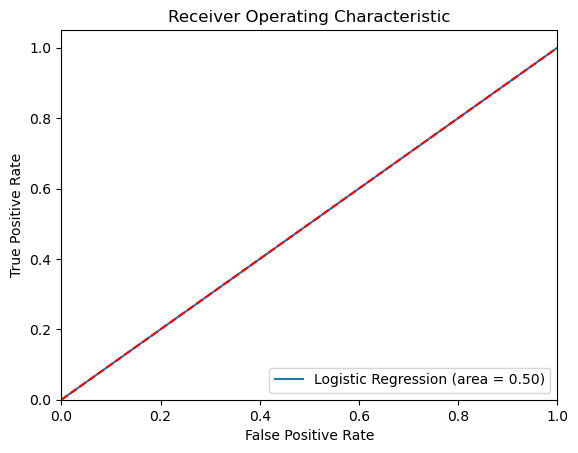

In [41]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_logistic)

plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % roc_auc_score(y_test, y_pred_logistic))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Model Comparison

Based on the provided accuracy, confusion matrices, classification reports, and AUC scores for the different models (Decision Tree, Random Forest Classifier, and Logistic Regression), here's a comparison and conclusion for each model's performance:

*Decision Tree:*

Accuracy: 0.99
AUC Score: 0.5
Precision and recall for the positive class (1) are low (0.17 and 0.22), indicating that it's not good at correctly classifying positive cases. The AUC score is also at the random chance level (0.5).
It performs well for the negative class (0), with high precision and recall.

*Random Forest Classifier:*

Accuracy: 0.994
AUC Score: 0.527
Precision and recall for the positive class (1) are still relatively low (0.05 and 0.70). 
While the AUC score is slightly better than random chance, it's still relatively low for a well-performing model.
It performs exceptionally well for the negative class (0).

*Logistic Regression:*

Accuracy: 0.9936
AUC Score: 0.5
Precision and recall for the positive class (1) are both very low (0.00).
It performs extremely well for the negative class (0).

**Conclusion:**

In all three models, there is a notable imbalance between the two classes. The models are much better at predicting the negative class (0) but struggle with the positive class (1). Further model tuning, feature engineering, or resampling techniques may be needed to improve performance.

The Random Forest Classifier has the highest accuracy (0.994) and the highest AUC score (0.527). The high accuracy suggests that it correctly classifies a significant portion of the dataset, and the AUC score indicates that it performs better than random guessing for distinguishing between the positive and negative classes.

### The Random Forest Classifier is the best model among the options for this particular classification task.